In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
import os

# Cheminformatics stack
import rdkit
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem import FragmentMatcher
from rdkit.Chem import rdFMCS
from glob import glob
from rdkit import Chem
from rdkit.Chem import Draw
# For segfault
import faulthandler
import signal
from subprocess import Popen, PIPE


In [7]:
def savexyz(mol, name):
    ps = rdDistGeom.ETKDG()
    ps.useRandomCoords = False
    try:
        mol2 = Chem.AddHs(mol)
        # AllChem.EmbedMolecule(mol2, ps)
        # Chem.MolToXYZFile(mol2, f"./XYZ_Structures_Generated/{name}.xyz")
        return mol2
    except Exception as m:
        return None

In [8]:
df = pd.read_csv("data/data_from_ruben/Base_Smiles.csv")

names = df.Structure.values
smiles = df.SMILES.values
charges = df.Charge.values

# Filter non-neutral molecules
neutral_ids = np.where(charges == 0)

names = names[neutral_ids]
smiles = smiles[neutral_ids]
charges = charges[neutral_ids]

print(f"A total of {names.shape[0]} neutral smiles were retained!")

# Filter molecules with weird SMILES
mols = np.array([Chem.MolFromSmiles(smi) for smi in smiles], dtype=object)
normal_ids = np.where(mols != None)

names = names[normal_ids]
smiles = smiles[normal_ids]
charges = charges[normal_ids]
mols = mols[normal_ids]

print(f"A total of {names.shape[0]} sanitized smiles were retained!")


A total of 3870 neutral smiles were retained!


[10:58:23] Explicit valence for atom # 29 N, 4, is greater than permitted
[10:58:23] Explicit valence for atom # 3 N, 4, is greater than permitted
[10:58:23] Explicit valence for atom # 3 N, 4, is greater than permitted
[10:58:23] Explicit valence for atom # 12 N, 4, is greater than permitted


A total of 3866 sanitized smiles were retained!


A total of 3735 unique smiles were retained!


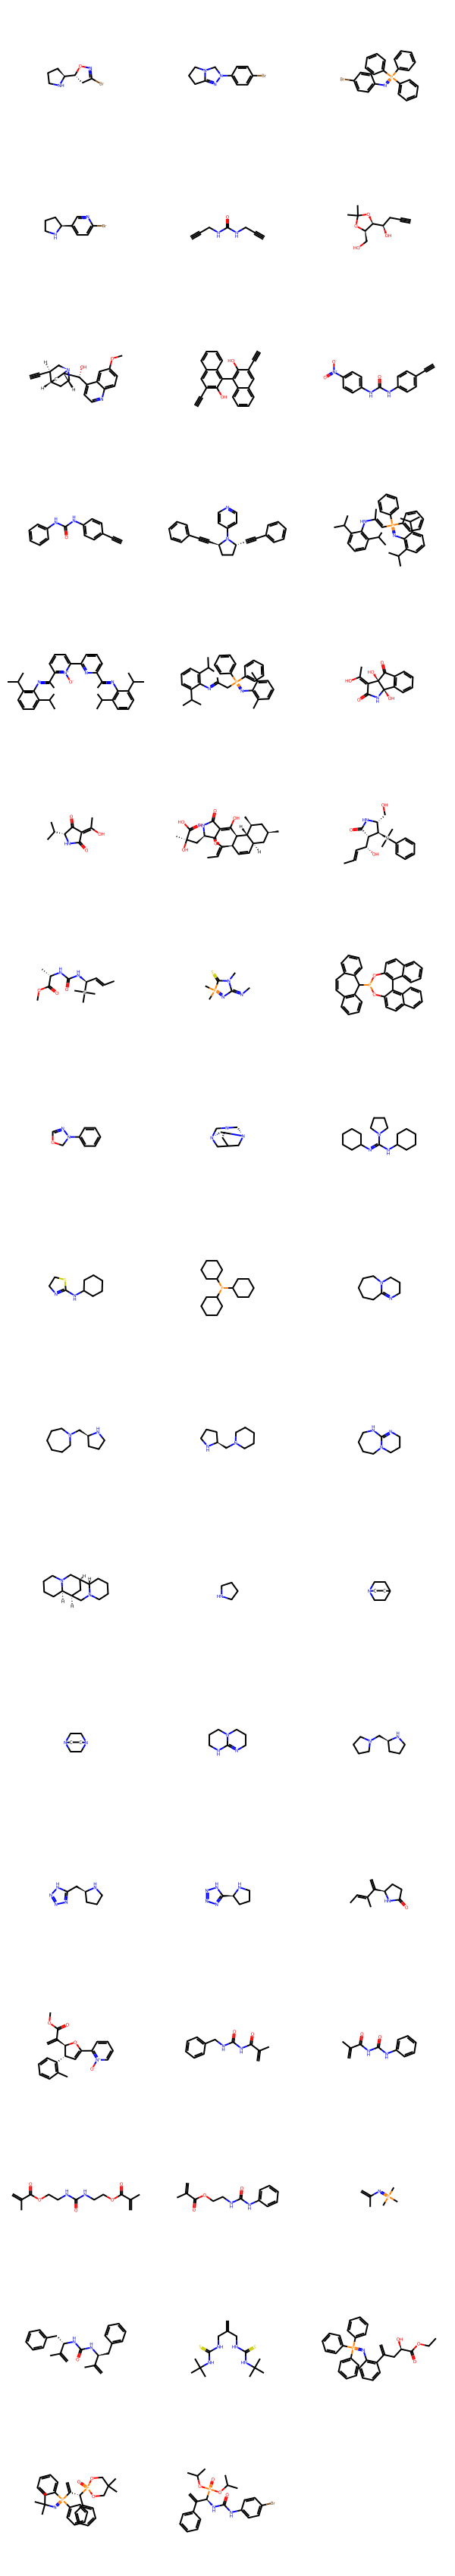

In [9]:
# Canonicalization of SMILES to remove duplicates

csmiles = np.array([Chem.MolToSmiles(mol) for mol in mols])
_, idx = np.unique(csmiles, return_index=True)
names = names[idx]
smiles = smiles[idx]
charges = charges[idx]
mols = mols[idx]
csmiles = csmiles[idx]

print(f"A total of {names.shape[0]} unique smiles were retained!")

img = Draw.MolsToGridImage(mols[:50], molsPerRow=3)
img

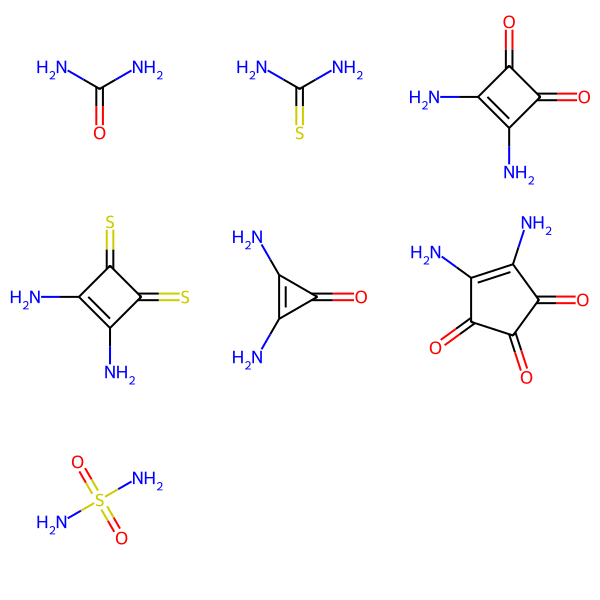

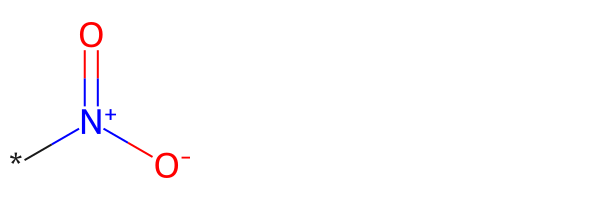

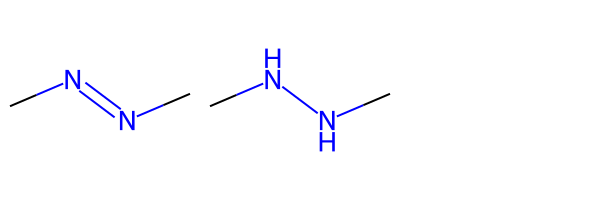

In [18]:
# Classification rules

patterns_catalytic = [
    "NC(N)=O",
    "NC(N)=S",
    "O=C1C(N)=C(N)C1=O",
    "S=C1C(N)=C(N)C1=S",
    "O=C1C(N)=C1N",
    "O=C(C(N)=C(N)C1=O)C1=O",
    "O=S(N)(N)=O",
]
patterns_inhibitor = [
    "*[N+]([O-])=O",
    #"*C(=O)",
]
patterns_photoactive = [
    "CN=NC",
    "CNNC",
]


moltype = np.zeros_like(names)
# draw mol patterns
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns_catalytic], dtype=object)
img = Draw.MolsToGridImage(mol_patterns, molsPerRow=3)
display(img)
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns_inhibitor], dtype=object)
img = Draw.MolsToGridImage(mol_patterns, molsPerRow=3)
display(img)
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns_photoactive], dtype=object)
display(Draw.MolsToGridImage(mol_patterns, molsPerRow=3))

In [19]:
# Method 2 using FragmentMatchers
def initialise_matchers(patterns):
    """Initialise fragment matchers for a list of patterns.

    Args:
    patterns: list of SMILES patterns

    Returns:
    pmatchers: list of FragmentMatcher objects
    """
    pmatchers = [FragmentMatcher.FragmentMatcher() for p in patterns]
    for p, pm in zip(patterns, pmatchers):
        pm.Init(p)
    return pmatchers


 number of linkers: 12345
 number of left blocks: 12345
 number of right blocks: 12345
 number of unique linkers: 7980
 number of unique right blocks: 12345
 number of unique left blocks: 12345
Linkers


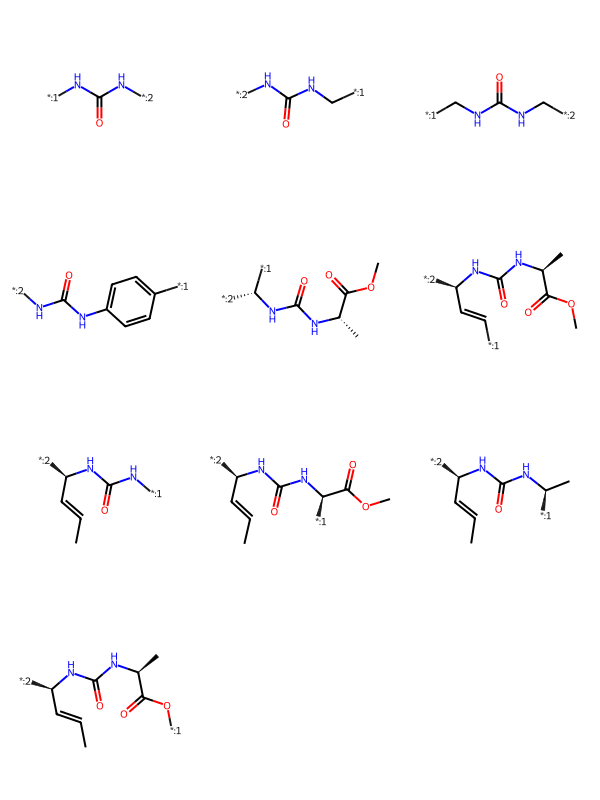

Right blocks


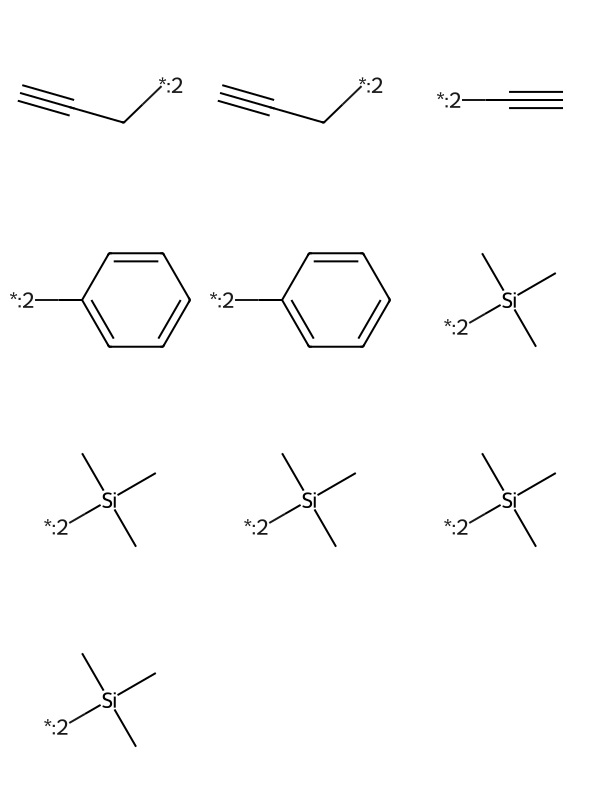

Left blocks


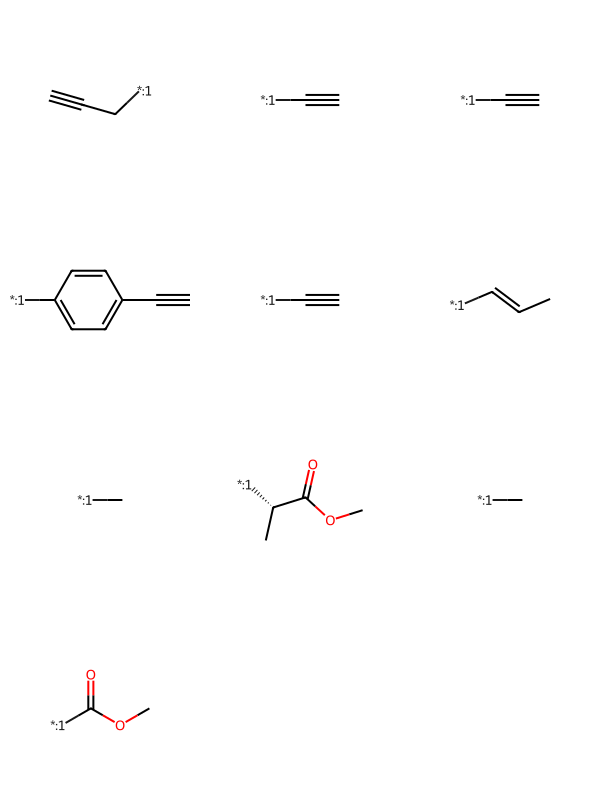

In [20]:
from rdkit.Chem import rdMMPA
def fragment_mols_to_3_parts(mols_list,patterns,pattern_not_to_match=None):
    """
    This function takes a list of molecules and fragments them into 3 parts: left block, linker and right block.
    The function returns 3 dataframes, one for each part.
    Parameters:
    mols_list: list of RDKit molecules
    """
    pmatchers = initialise_matchers(patterns)
    pmatchers_not_to_match = initialise_matchers(pattern_not_to_match)
    linker_list = []
    Left_block = []
    Right_block = []
    for mols in mols_list:
        frag3 = rdMMPA.FragmentMol(mols)

        for frag in frag3:
            if frag[0] is not None:
                #display(Draw.MolsToGridImage(frag3[1]))
                frag_smiles_ = Chem.MolToSmiles(frag[1]).split('.')
                if len(frag_smiles_) == 2:
                    if any([pm.HasMatch(frag[0]) for pm in pmatchers]):
                        if any([pm.HasMatch(frag[0]) for pm in pmatchers_not_to_match]):
                            continue
                        if any([pm.HasMatch(frag[1]) for pm in pmatchers_not_to_match]):
                            continue
                        linker_list.append(frag[0])
                        if '*:1' in frag_smiles_[0]:
                            Left_block.append( Chem.MolFromSmiles(frag_smiles_[0]))
                            Right_block.append( Chem.MolFromSmiles(frag_smiles_[1]))
                        else:
                            Left_block.append( Chem.MolFromSmiles(frag_smiles_[1]))
                            Right_block.append( Chem.MolFromSmiles(frag_smiles_[0]))
    print(' number of linkers:', len(linker_list))  
    print(' number of left blocks:', len(Left_block))
    print(' number of right blocks:', len(Right_block))
    df_linkers= pd.DataFrame({'linker':linker_list, 'smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    df_linkers.drop_duplicates(subset=['smiles'],inplace=True) 
    print(' number of unique linkers:', df_linkers.shape[0])
    df_linkers.head()
    df_right_block = pd.DataFrame({'right_block':Right_block, 'smiles': [Chem.MolToSmiles(m) for m in Right_block],'linkers_smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    #df_right_block.drop_duplicates(subset=['smiles'],inplace=True)
    print(' number of unique right blocks:', df_right_block.shape[0])
    df_left_block = pd.DataFrame({'left_block':Left_block, 'smiles': [Chem.MolToSmiles(m) for m in Left_block],'linkers_smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    #df_left_block.drop_duplicates(subset=['smiles'],inplace=True)
    print(' number of unique left blocks:', df_left_block.shape[0])
    return df_linkers, df_left_block, df_right_block

pattern_not_to_match = patterns_photoactive
pattern_not_to_match.extend(patterns_inhibitor)
df_linkers, df_left_block, df_right_block = fragment_mols_to_3_parts(mols,patterns_catalytic,pattern_not_to_match)
print('Linkers')
display(Draw.MolsToGridImage(df_linkers['linker'][:10]))
print('Right blocks')
display(Draw.MolsToGridImage(df_right_block['right_block'][:10]))
print('Left blocks')
display(Draw.MolsToGridImage(df_left_block['left_block'][:10]))


In [21]:
df_right_block.drop_duplicates(subset=['smiles','linkers_smiles'],inplace=True)
print(' number of unique right blocks:', df_right_block.shape[0])
df_right_block.to_csv('catalyst_right_blocks.csv',index=False)

 number of unique right blocks: 10908


Unique substituents detected: 685


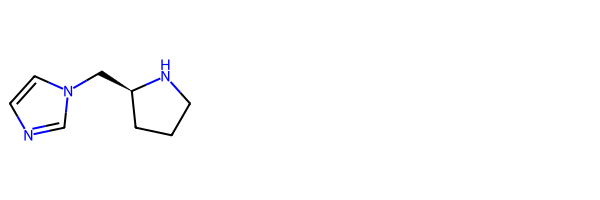

In [10]:
def generate_unique_frag(mol,patterns):
    fragsmiles, fragmols, fragaps, fraparent, fraparentmol = [], [], [], [], []
    pmatchers = initialise_matchers(patterns)
    for j, pm in enumerate(pmatchers):
        if pm.HasMatch(mol):
            #print(f"{csmiles[i]} seems to contain {patterns[j]}")
            #moltype[i] = j + 1
            matches = pm.GetMatches(mol)
            bonds_to_cut = []
            for idx in matches[0]:
                for n in mol.GetAtomWithIdx(idx).GetNeighbors():
                    nidx = n.GetIdx()
                    if nidx not in matches[0]:
                        bonds_to_cut.append(mol.GetBondBetweenAtoms(idx, nidx))
            if bonds_to_cut:
                posi_ids = [b.GetBeginAtomIdx() for b in bonds_to_cut]
                pose_ids = [b.GetEndAtomIdx() for b in bonds_to_cut]
                bond_ids = [b.GetIdx() for b in bonds_to_cut]
                temp_mol_f = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
                fmols = Chem.GetMolFrags(temp_mol_f, asMols=True)
                fatoms = Chem.GetMolFrags(temp_mol_f)
                for fmol, fatom in zip(fmols, fatoms):
                    fatom = list(fatom)
                    if not pm.HasMatch(fmol):
                        fragsmiles.append(Chem.MolToSmiles(fmol))
                        fragmols.append(fmol)
                        # print(posi_ids, pose_ids, fatom)
                        if any(a in posi_ids for a in fatom):
                            for pos in posi_ids:
                                if pos in fatom:
                                    fatom_ap_idx = list(fatom).index(pos)
                        elif any(a in pose_ids for a in fatom):
                            for pos in pose_ids:
                                if pos in fatom:
                                    fatom_ap_idx = list(fatom).index(pos)
                        fragaps.append(fatom_ap_idx)
                        #fraparent.append(names[i])
                        fraparentmol.append(mol)
    return fragsmiles, fragmols, fragaps, fraparent, fraparentmol
fragsmiles, fragmols, fragaps, fraparent, fraparentmol = [], [], [], [], []
for mol in mols:
    fragsmile, fragmol, fragap, fraparent_, fraparentmol_ = generate_unique_frag(mol,patterns)
    fragsmiles += fragsmile
    fragmols += fragmol
    fragaps += fragap
    fraparent += fraparent_
    fraparentmol += fraparentmol_

fragsmiles, idx = np.unique(np.array(fragsmiles), return_index=True)
fragmols_plot = fragmol.copy()
fragmols_plot = np.array(fragmols_plot, dtype=object)
fragmols_plot = np.append(fragmols_plot, mol)
fragmols = np.array(fragmols, dtype=object)[idx]
fragaps = np.array(fragaps, dtype=int)[idx]
#fraparent = np.array(fraparent)[idx]
fraparentmol = np.array(fraparentmol)[idx]

print(f"Unique substituents detected: {fragsmiles.shape[0]}")
img = Draw.MolsToGridImage(fragmols_plot, molsPerRow=3)
img

Unique substituents detected: 685


[10:49:44] WARNING: bond found with stereo spec but no stereo atoms
[10:49:44] WARNING: bond found with stereo spec but no stereo atoms
[10:49:44] WARNING: bond found with stereo spec but no stereo atoms
[10:49:44] WARNING: bond found with stereo spec but no stereo atoms


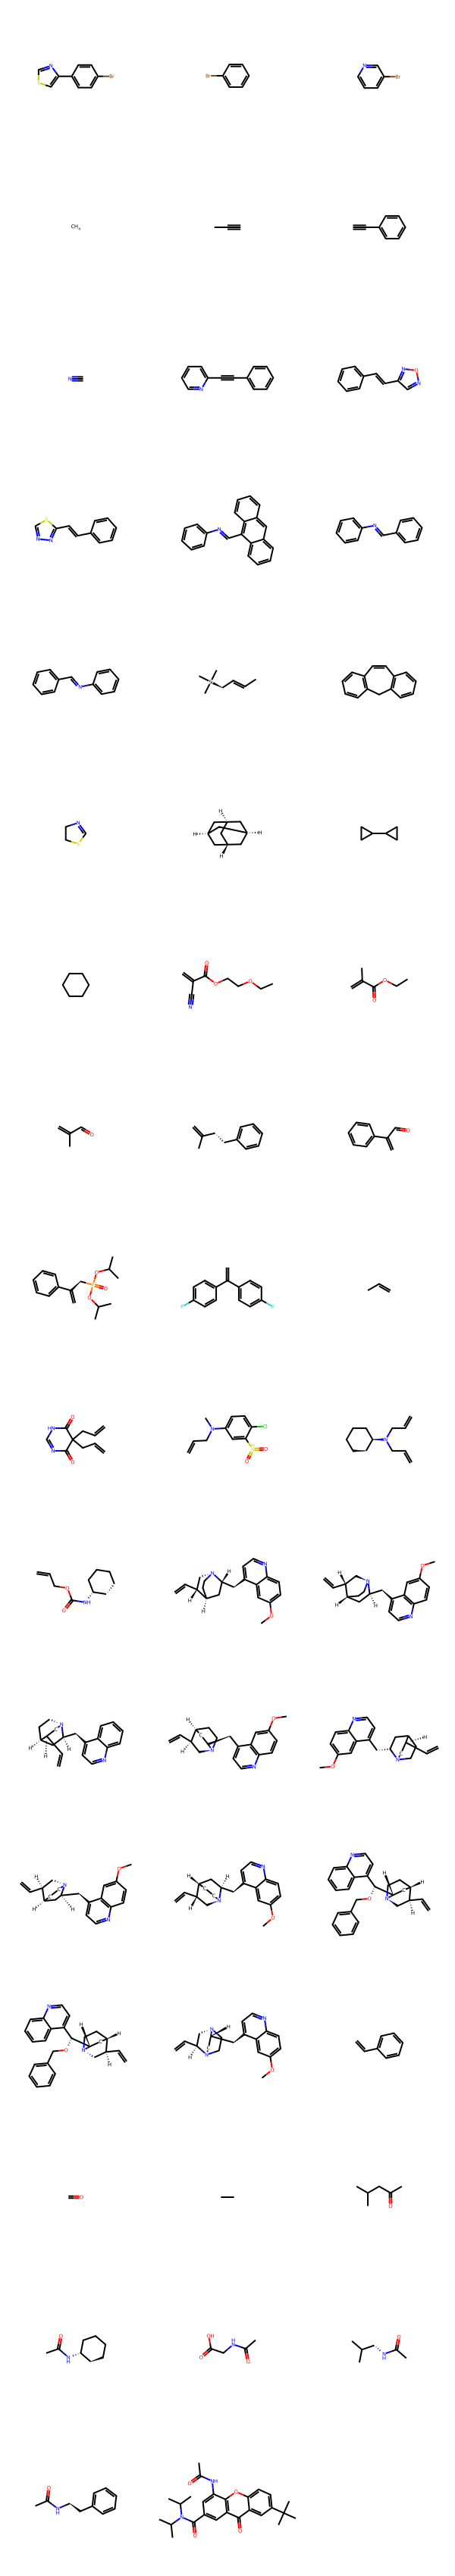

In [11]:


print(f"Unique substituents detected: {fragsmiles.shape[0]}")
img = Draw.MolsToGridImage(fragmols[:50], molsPerRow=3)
img

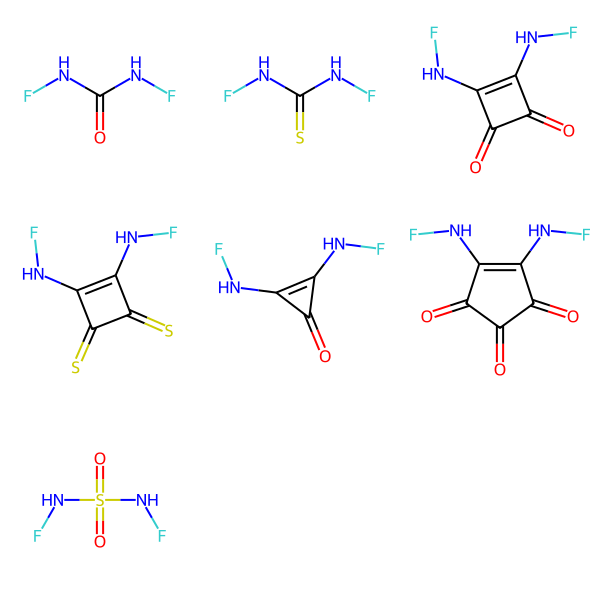

In [144]:
patterns_f = [
        "FNC(N(F))=O",
        "FNC(N(F))=S",
        "O=C1C(N(F))=C(N(F))C1=O",
        "S=C1C(N(F))=C(N(F))C1=S",
        "O=C1C(N(F))=C1N(F)",
        "O=C(C(N(F))=C(N(F))C1=O)C1=O",
        "O=S(N(F))(N(F))=O",
    ]
mol_patterns_f = np.array(
    [Chem.MolFromSmiles(smi) for smi in patterns_f], dtype=object
)
img = Draw.MolsToGridImage(mol_patterns_f, molsPerRow=3)
img

In [161]:
def assemble_molecule(core_flurinated, fragmolr1, fragmolr2):
    template = copy.deepcopy(core_flurinated)

    r1 = copy.deepcopy(fragmolr1)
    r2 = copy.deepcopy(fragmolr2)
    mod_mol1 = Chem.ReplaceSubstructs(
        template,
        Chem.MolFromSmiles("F"),
        r1,
        False,
        int(fragaps[i1]),
    )[0]
    # print(
    #    f"Substitution 1 done, current molecule SMILES is {Chem.MolToSmiles(mod_mol1)}"
    # )
    # print(f"Adding {fragsmiles[i1]}")
    mod_mol12 = Chem.ReplaceSubstructs(
        mod_mol1,
        Chem.MolFromSmiles("F"),
        r2,
        False,
        int(fragaps[i2]),
    )[0]
    #check valence errors
    problems = Chem.DetectChemistryProblems(mod_mol12)
    if problems:
        #print(problems)
        return None
    else:
        Chem.SanitizeMol(
                    mod_mol12,
                    sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL
                    ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE
                    ^ Chem.SanitizeFlags.SANITIZE_SETAROMATICITY,
                )
        currsmiles = Chem.MolToSmiles(mod_mol12)
        return mod_mol12
assemble_molecule(mol_patterns_f[0], fragmols[0], fragmols[1])

[14:54:25] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 15


In [165]:
finalmols = []
finalsmiles = []
count = 0
fragidx = np.arange(fragsmiles.shape[0])
for mol_pattern_f in mol_patterns_f[:1]:
    print(f"Starting from template {Chem.MolToSmiles(mol_pattern_f)},")
    for i1, i2 in itertools.combinations_with_replacement(fragidx, 2):
        count += 1
        mod_mol12= assemble_molecule(mol_pattern_f, fragmols[i1], fragmols[i2])
        if mod_mol12 is None:
            continue
        currsmiles = Chem.MolToSmiles(mod_mol12)
        finalsmiles.append(currsmiles)
        finalmols.append(mod_mol12)

finalsmiles = np.array(finalsmiles)
finalmols = np.array(finalmols)
print(
    f"{finalsmiles.shape[0]} molecules generated from substitutions using fragments."
)
finalsmiles, idx = np.unique(finalsmiles, return_index=True)
finalmols = finalmols[idx]
print(
    f"{finalsmiles.shape[0]} unique molecules generated from substitutions using fragments."
)

Starting from template O=C(NF)NF,


[14:55:46] Explicit valence for atom # 17 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 26 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 17 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 16 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 26 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 22 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom # 22 C, 5, is greater than permitted
[14:55:46] Explicit valence for atom #

KeyboardInterrupt: 

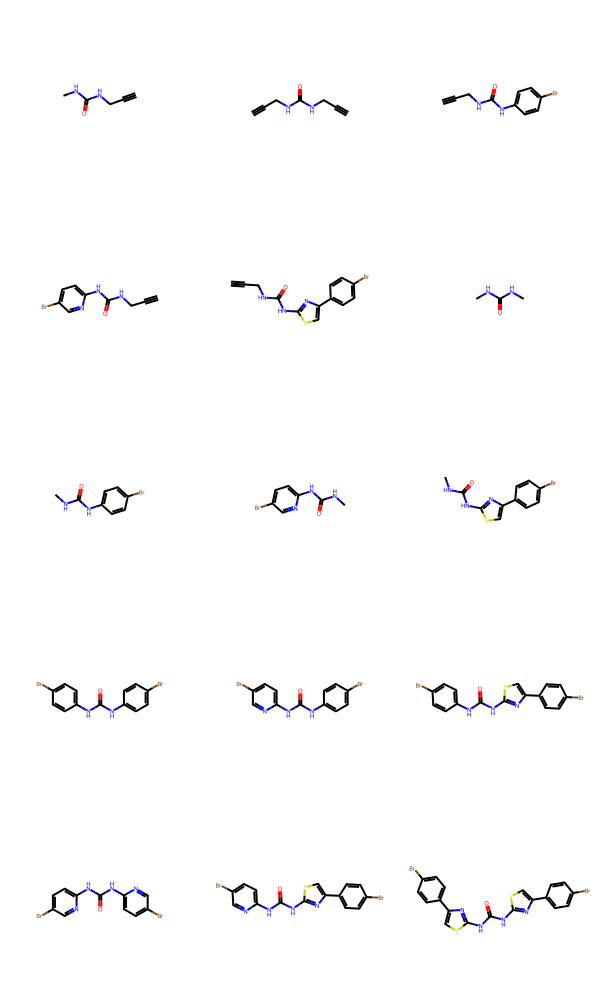

[15:00:22] WARNING: bond found with stereo spec but no stereo atoms
[15:00:22] WARNING: bond found with stereo spec but no stereo atoms
[15:00:22] WARNING: bond found with stereo spec but no stereo atoms
[15:00:22] WARNING: bond found with stereo spec but no stereo atoms
[15:00:23] WARNING: bond found with stereo spec but no stereo atoms


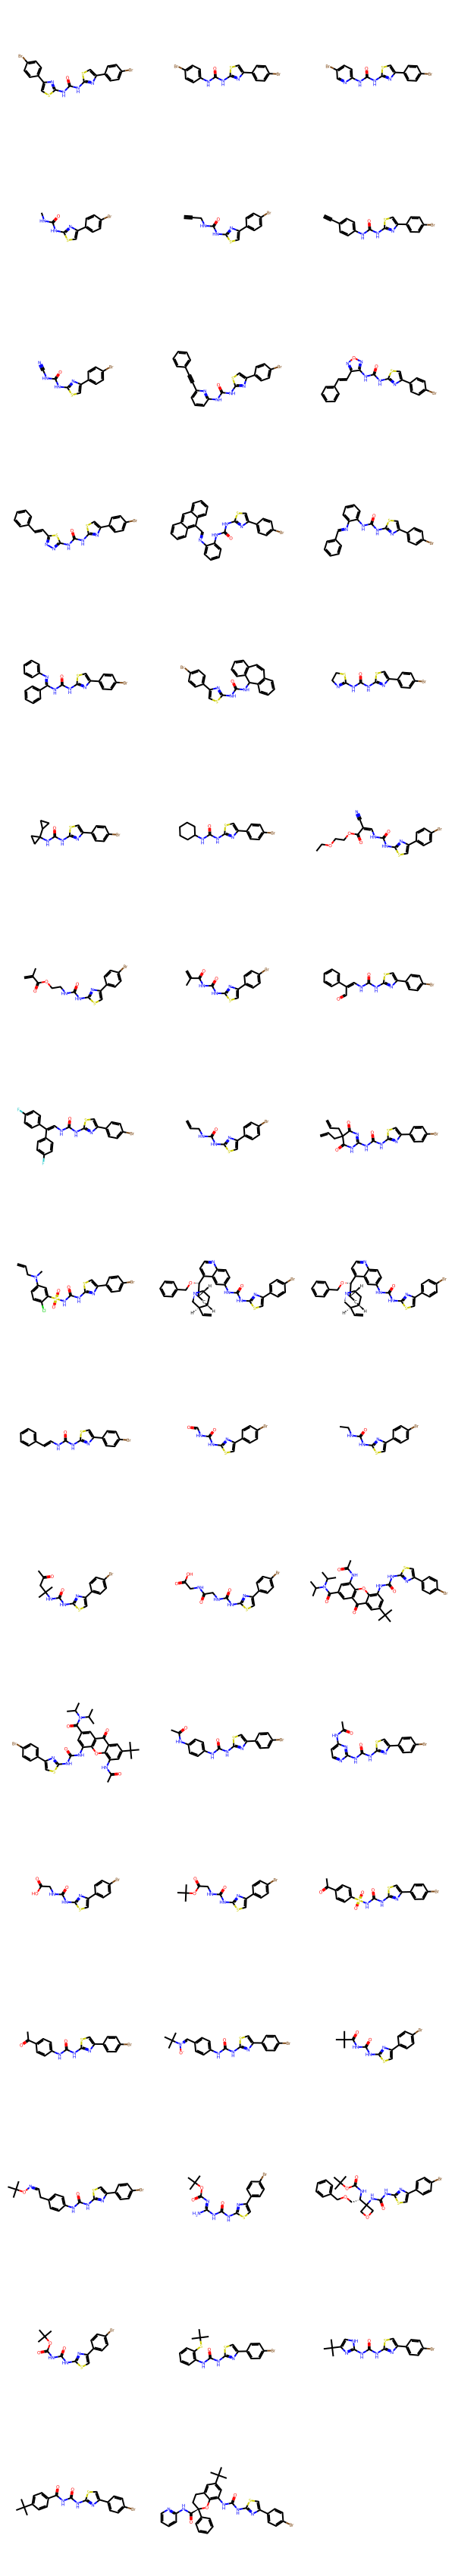

In [ ]:
img = Draw.MolsToGridImage(finalmols[:50], molsPerRow=3)
img